In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


#from keras.layers import Dense, Input
#from keras.models import Model

#import omnifold6b as of

#import tensorflow as tf

#import simple_pdf2b as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
#print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]






#--- perfect
#resolution = [ 0.000001  ]

#--- very good
#resolution = [ 0.05  ]

#--- good
#resolution = [ 0.25  ]

#--- nominal
resolution = [ 0.5  ]

#--- medium poor
#resolution = [ 0.75  ]

#--- poor
#resolution = [ 1.0  ]







train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






#ngen_train = 100000
#ngen_true =   10000

#ngen_train = 1000000
#ngen_true =   100000

of_niter = 5





do_bootstrap = False

n_boot_samples = 500



ds_input_dir = 'toy-study6b-1d-1a-10k'


output_dir = 'hist-pdf-toy-study-1d-2b'

#save_step2_model = True



hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.3

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins






 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100
 window_nbins : 15


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.3,
 'window_nbins': 15}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [7]:
train_cov_inv = np.linalg.inv( train_cov )

In [8]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [9]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [10]:
true_cov_inv = np.linalg.inv( true_cov )

In [11]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [12]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [13]:

#--- Read the datasets instead of generating new ones.

train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )



#with open('%s/train-and-true-samples.npy' % ds_input_dir, 'rb') as f :
#    train_pts = np.load(f)
#    train_det_pts = np.load(f)
#    true_pts = np.load(f)
#    true_det_pts = np.load(f)

print('\n\n train_pts:')
print( train_pts )
print('\n\n')
print(' train_pts shape:  %s' % str(train_pts.shape))

train_both = np.stack([train_pts, train_det_pts], axis=1)
    
#-- ok to regenerate these (just for plots)
true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights




 train_pts:
[[-1.89397847]
 [-0.59989927]
 [-2.15718988]
 ...
 [-0.30558701]
 [-1.28214576]
 [ 0.63250182]]



 train_pts shape:  (1000000, 1)


In [14]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [15]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [16]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )



config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : hist-pdf-toy-study-1d-2a/config.txt

2024-07-12 21:56:34.948583

ngen_train 1000000
ngen_true  100000
of_niter   5
ndim       1


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.75]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

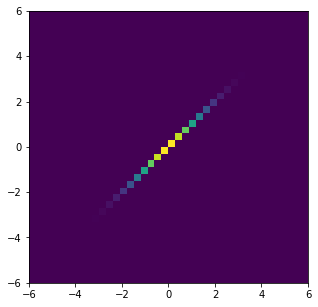

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

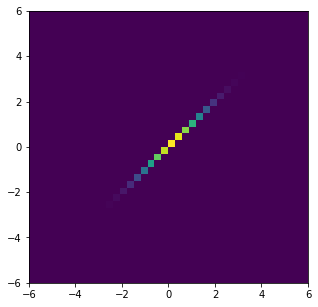

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

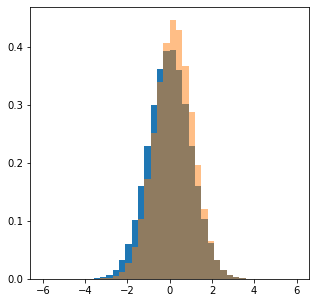

In [19]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [20]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-1.89397847]
 [-0.59989927]
 [-2.15718988]
 ...
 [-0.30558701]
 [-1.28214576]
 [ 0.63250182]]


In [21]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-2.09397847]
 [-0.79989927]
 [-2.35718988]
 ...
 [-0.50558701]
 [-1.48214576]
 [ 0.43250182]]


In [22]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [23]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [24]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [25]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [26]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [27]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [28]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [29]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [30]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.09386083 0.47127923 0.05507282 ... 0.53845215 0.24800315 0.46190584]


In [31]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.04185108 0.42233068 0.02030585 ... 0.535372   0.16153609 0.55851588]


In [32]:
pdf_ratio = pdf_true / pdf_train

In [33]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [34]:
calc_weight = pdf_ratio

In [35]:
calc_weight_scaled = sample_sf * pdf_ratio

In [36]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Define function for calculating model pars (mean and cov) from weighted events

In [37]:
def calc_mean_cov( weights, fi1, fi2, sample_points ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * sample_points[:,fi1] )
    wx2 = np.sum( weights * sample_points[:,fi2] )
    wx1x2 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * sample_points[:,fi1] * sample_points[:,fi1] )
        wx2x2 = np.sum( weights * sample_points[:,fi2] * sample_points[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [38]:
weights_true = np.ones( ngen_true )

In [39]:
true_calc_mean = np.zeros( ndim )
true_calc_cov = np.ones( shape=(ndim,ndim) )

In [40]:
for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        rd = calc_mean_cov( weights_true, fi1, fi2, true_pts )
        true_calc_mean[fi1] = rd['mean_x1']
        true_calc_cov[fi1,fi2] = rd['cov_x1x2']

In [41]:
for fi1 in range(ndim) :
    print('  mean f%d :  %7.3f' % (fi1, true_calc_mean[fi1]))
    for fi2 in range(fi1,ndim) :
        print('  cov f%df%d :  %7.4f' % (fi1,fi2, true_calc_cov[fi1,fi2]))
        if fi1 == fi2 :
            print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(true_calc_cov[fi1,fi1])))
        

  mean f0 :    0.199
  cov f0f0 :   0.8055
  sigma f0 :   0.8975


In [42]:
print( true_pts.shape )
print( true_pts.shape[1])

(100000, 1)
1


In [43]:
def calc_model_pars( weights, sample_points, verbose=0 ) :
    
    return_dict = {}
    
    ndim = sample_points.shape[1]
    if verbose : print(' ndim = %d' % ndim )
    
    model_mean = np.zeros( ndim )
    model_cov = np.ones( shape=(ndim,ndim) )
    
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            rd = calc_mean_cov( weights, fi1, fi2, sample_points )
            model_mean[fi1] = rd['mean_x1']
            model_cov[fi1,fi2] = rd['cov_x1x2']    
            if verbose and fi2==fi1 : print('  mean f%d :  %7.3f' % (fi1, model_mean[fi1]))
            if verbose : print('  cov f%df%d :  %7.4f' % (fi1,fi2, model_cov[fi1,fi2]))
            if verbose and fi2==fi1 : print('  sigma f%d :  %7.4f' % (fi1, np.sqrt(model_cov[fi1,fi1])))
   
    for fi2 in range(ndim) :
        for fi1 in range(fi2+1,ndim) :
            model_cov[fi1,fi2] = model_cov[fi2,fi1]
    
    return_dict['mean'] = model_mean
    return_dict['cov']  = model_cov
    
    return return_dict


In [44]:
test_calc_true_model = calc_model_pars( weights_true, true_pts, 1)

 ndim = 1
  mean f0 :    0.199
  cov f0f0 :   0.8055
  sigma f0 :   0.8975


In [45]:
test_calc_true_model

{'mean': array([0.19941976]), 'cov': array([[0.80553925]])}

## Define function to calculate the reweighting factor (pdf2/pdf1).

In [46]:
def calc_pdf_ratio( model1_mu, model2_mu, model1_cov, model2_cov, sample_points ) :
    
    ndim = len(model1_mu)
    
    pts_minus_mu1 = sample_points - model1_mu
    pts_minus_mu2 = sample_points - model2_mu
    
    cov1_inv = np.linalg.inv( model1_cov )
    cov2_inv = np.linalg.inv( model2_cov )
    
    cov1_det = np.linalg.det( model1_cov )
    cov2_det = np.linalg.det( model2_cov )
    
    cov1_inv_times_v1 = np.tensordot( cov1_inv, pts_minus_mu1.T, axes=(1,0) )
    cov2_inv_times_v2 = np.tensordot( cov2_inv, pts_minus_mu2.T, axes=(1,0) )
    
    v1_times_cov1_inv_times_v1 =  np.sum( pts_minus_mu1.T * cov1_inv_times_v1, axis=0)
    v2_times_cov2_inv_times_v2 =  np.sum( pts_minus_mu2.T * cov2_inv_times_v2, axis=0)
    
    exp_v1_times_cov1_inv_times_v1 = np.exp( -0.5 * v1_times_cov1_inv_times_v1 )
    exp_v2_times_cov2_inv_times_v2 = np.exp( -0.5 * v2_times_cov2_inv_times_v2 )
    
    norm2_model1 = np.power( 3.14159265, ndim) * cov1_det
    norm2_model2 = np.power( 3.14159265, ndim) * cov2_det
    
    pdf1 = exp_v1_times_cov1_inv_times_v1 / np.sqrt(norm2_model1)
    pdf2 = exp_v2_times_cov2_inv_times_v2 / np.sqrt(norm2_model2)
    
    pdf_ratio = pdf1 / pdf2
    
    return pdf_ratio
    
    

In [47]:
test_calc_pdf_ratio = calc_pdf_ratio( true_mu, train_mu, true_cov, train_cov, train_pts )

In [48]:
test_calc_pdf_ratio

array([0.44588443, 0.89613683, 0.36870904, ..., 0.99427962, 0.65134693,
       1.20915528])

In [49]:
pdf_ratio

array([0.44588443, 0.89613683, 0.36870904, ..., 0.99427962, 0.65134693,
       1.20915528])

## Function that estimates the pdf from a histogram (multi-bin sum)

In [50]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

In [51]:
print('pdf_ratio shape : %s' % str(pdf_ratio.shape))

pdf_ratio shape : (1000000,)


In [52]:
weights_true = np.ones( ngen_true )
weights_train = np.ones( ngen_train )

print(' train_pts shape: %s' % str(train_pts.shape))
print('  true_pts shape: %s' % str(true_pts.shape))
print(' weights_train shape: %s' % str(weights_train.shape))
print('  weights_true shape: %s' % str(weights_true.shape))

test_hist_pdf_ratio = pdf_ratio_from_hist( train_pts, true_pts, weights_train, weights_true, hist_pars )

 train_pts shape: (1000000, 1)
  true_pts shape: (100000, 1)
 weights_train shape: (1000000,)
  weights_true shape: (100000,)


In [53]:
pdf_ratio

array([0.44588443, 0.89613683, 0.36870904, ..., 0.99427962, 0.65134693,
       1.20915528])

In [54]:
calc_weight

array([0.44588443, 0.89613683, 0.36870904, ..., 0.99427962, 0.65134693,
       1.20915528])

In [55]:
test_hist_pdf_ratio

array([0.46832702, 0.88997587, 0.39454277, ..., 0.97960563, 0.66514648,
       1.20857013])

In [56]:
test_hist_pdf_ratio.shape

(1000000,)

In [57]:
for pi in range(40) :
    print( ' %3d   x %7.3f   true  %7.4f  from hist %7.4f' % (pi, train_pts[pi,0], calc_weight[pi], test_hist_pdf_ratio[pi]))

   0   x  -1.894   true   0.4459  from hist  0.4683
   1   x  -0.600   true   0.8961  from hist  0.8900
   2   x  -2.157   true   0.3687  from hist  0.3945
   3   x   0.137   true   1.1188  from hist  1.1201
   4   x  -1.131   true   0.7056  from hist  0.7187
   5   x   0.141   true   1.1199  from hist  1.1246
   6   x  -0.731   true   0.8500  from hist  0.8463
   7   x   0.364   true   1.1677  from hist  1.1689
   8   x   0.855   true   1.2288  from hist  1.2262
   9   x   0.116   true   1.1137  from hist  1.1152
  10   x   0.485   true   1.1886  from hist  1.1915
  11   x  -0.513   true   0.9261  from hist  0.9172
  12   x   0.923   true   1.2320  from hist  1.2331
  13   x   0.854   true   1.2288  from hist  1.2262
  14   x   1.254   true   1.2286  from hist  1.2328
  15   x  -1.430   true   0.5992  from hist  0.6159
  16   x   1.526   true   1.2025  from hist  1.1963
  17   x  -2.539   true   0.2720  from hist  0.2631
  18   x  -0.012   true   1.0809  from hist  1.0755
  19   x   0

## Define OmniFold implementation with fit pdf

In [58]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    
    #model_pars_theta_unknown_S = calc_model_pars( np.ones( ngen_true ), theta_unknown_S, verbose )
    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        
        #model_pars_theta0_S = calc_model_pars( weights_push, theta0_S, verbose )
        
        #pdf_ratio_step1 = calc_pdf_ratio( model_pars_theta_unknown_S['mean'],
        #                           model_pars_theta0_S['mean'],
        #                           model_pars_theta_unknown_S['cov'],
        #                           model_pars_theta0_S['cov'],
        #                           theta0_S )

        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [59]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (1000000, 1)
  shape of theta0_G : (1000000, 1)
  shape of theta_unknown_S : (100000, 1)

  iterations = 5

  ndim : 1
  neval_train : 1000000
  neval_true  : 100000





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (1000000,) 
[0.61145694 0.64367716 0.60885301 ... 1.1579851  0.7139859  0.97618602]
  iter 1, step1_output_weights:  shape (1000000,)
[0.61145694 0.64367716 0.60885301 ... 1.1579851  0.7139859  0.97618602]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.69827692 0.93704109 0.64893554 ... 0.98201015 0.81112671 1.10221391]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.69827692 0.93704109 0.64893554 ... 0.98201015 0.81112671 1.10221391]
 pdf_ratio_step1:  shape (1000000,) 
[0.77862728 0.80355333 0.77990952 ... 1.06838996 0.84740517 1.00141283]
  ite

In [60]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

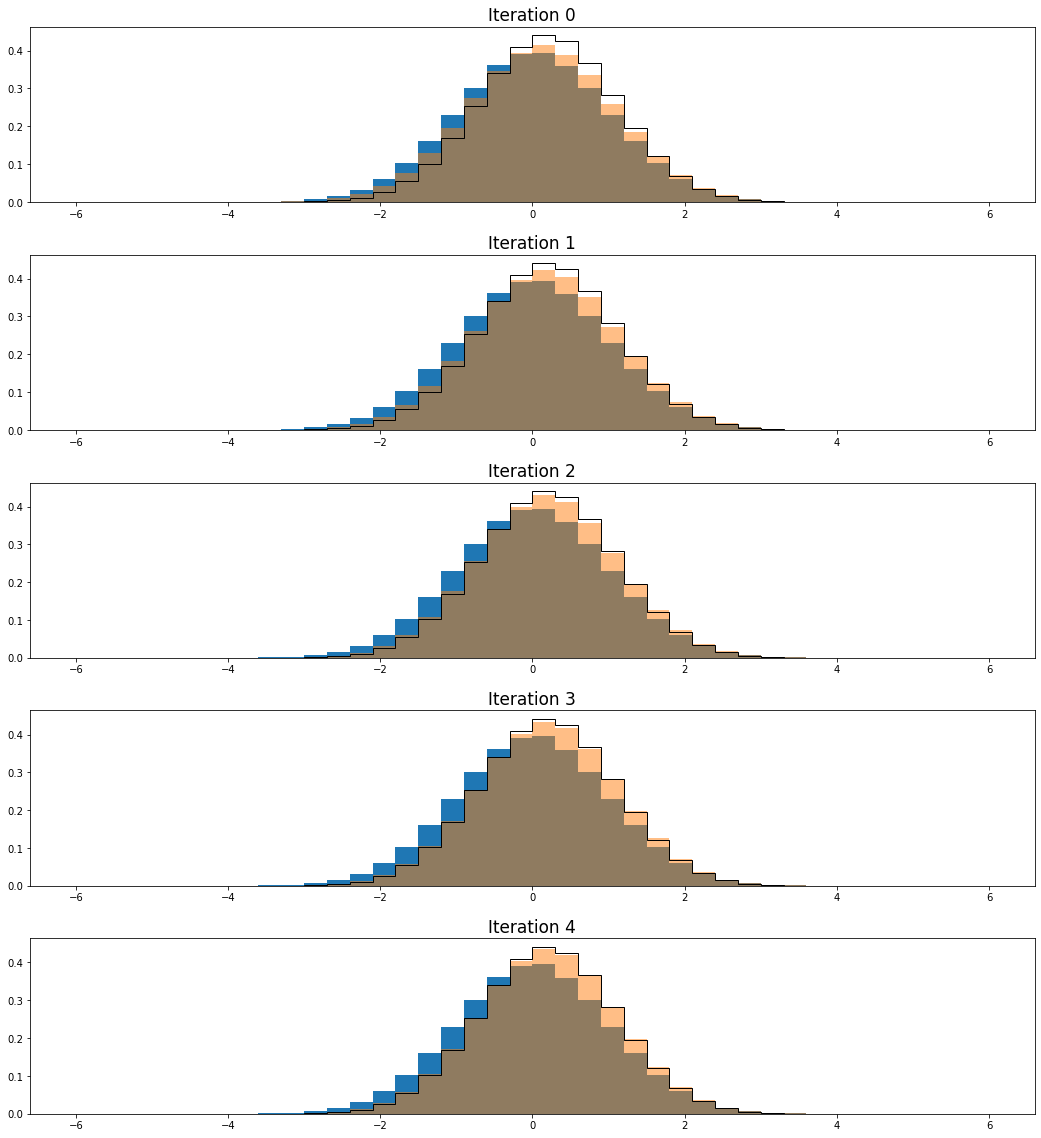

In [61]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [62]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

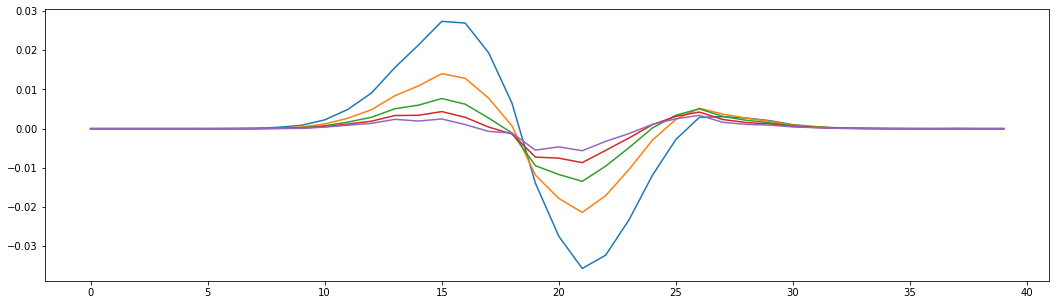

In [63]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

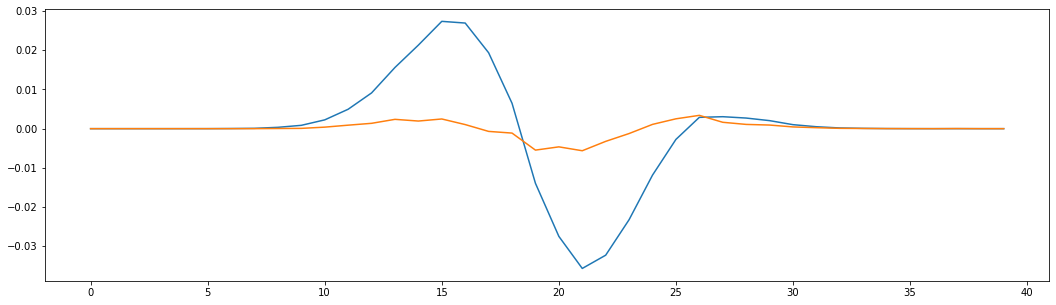

In [64]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

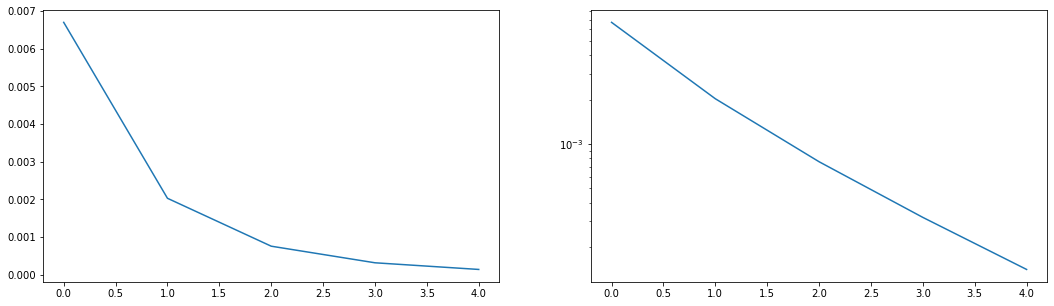

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

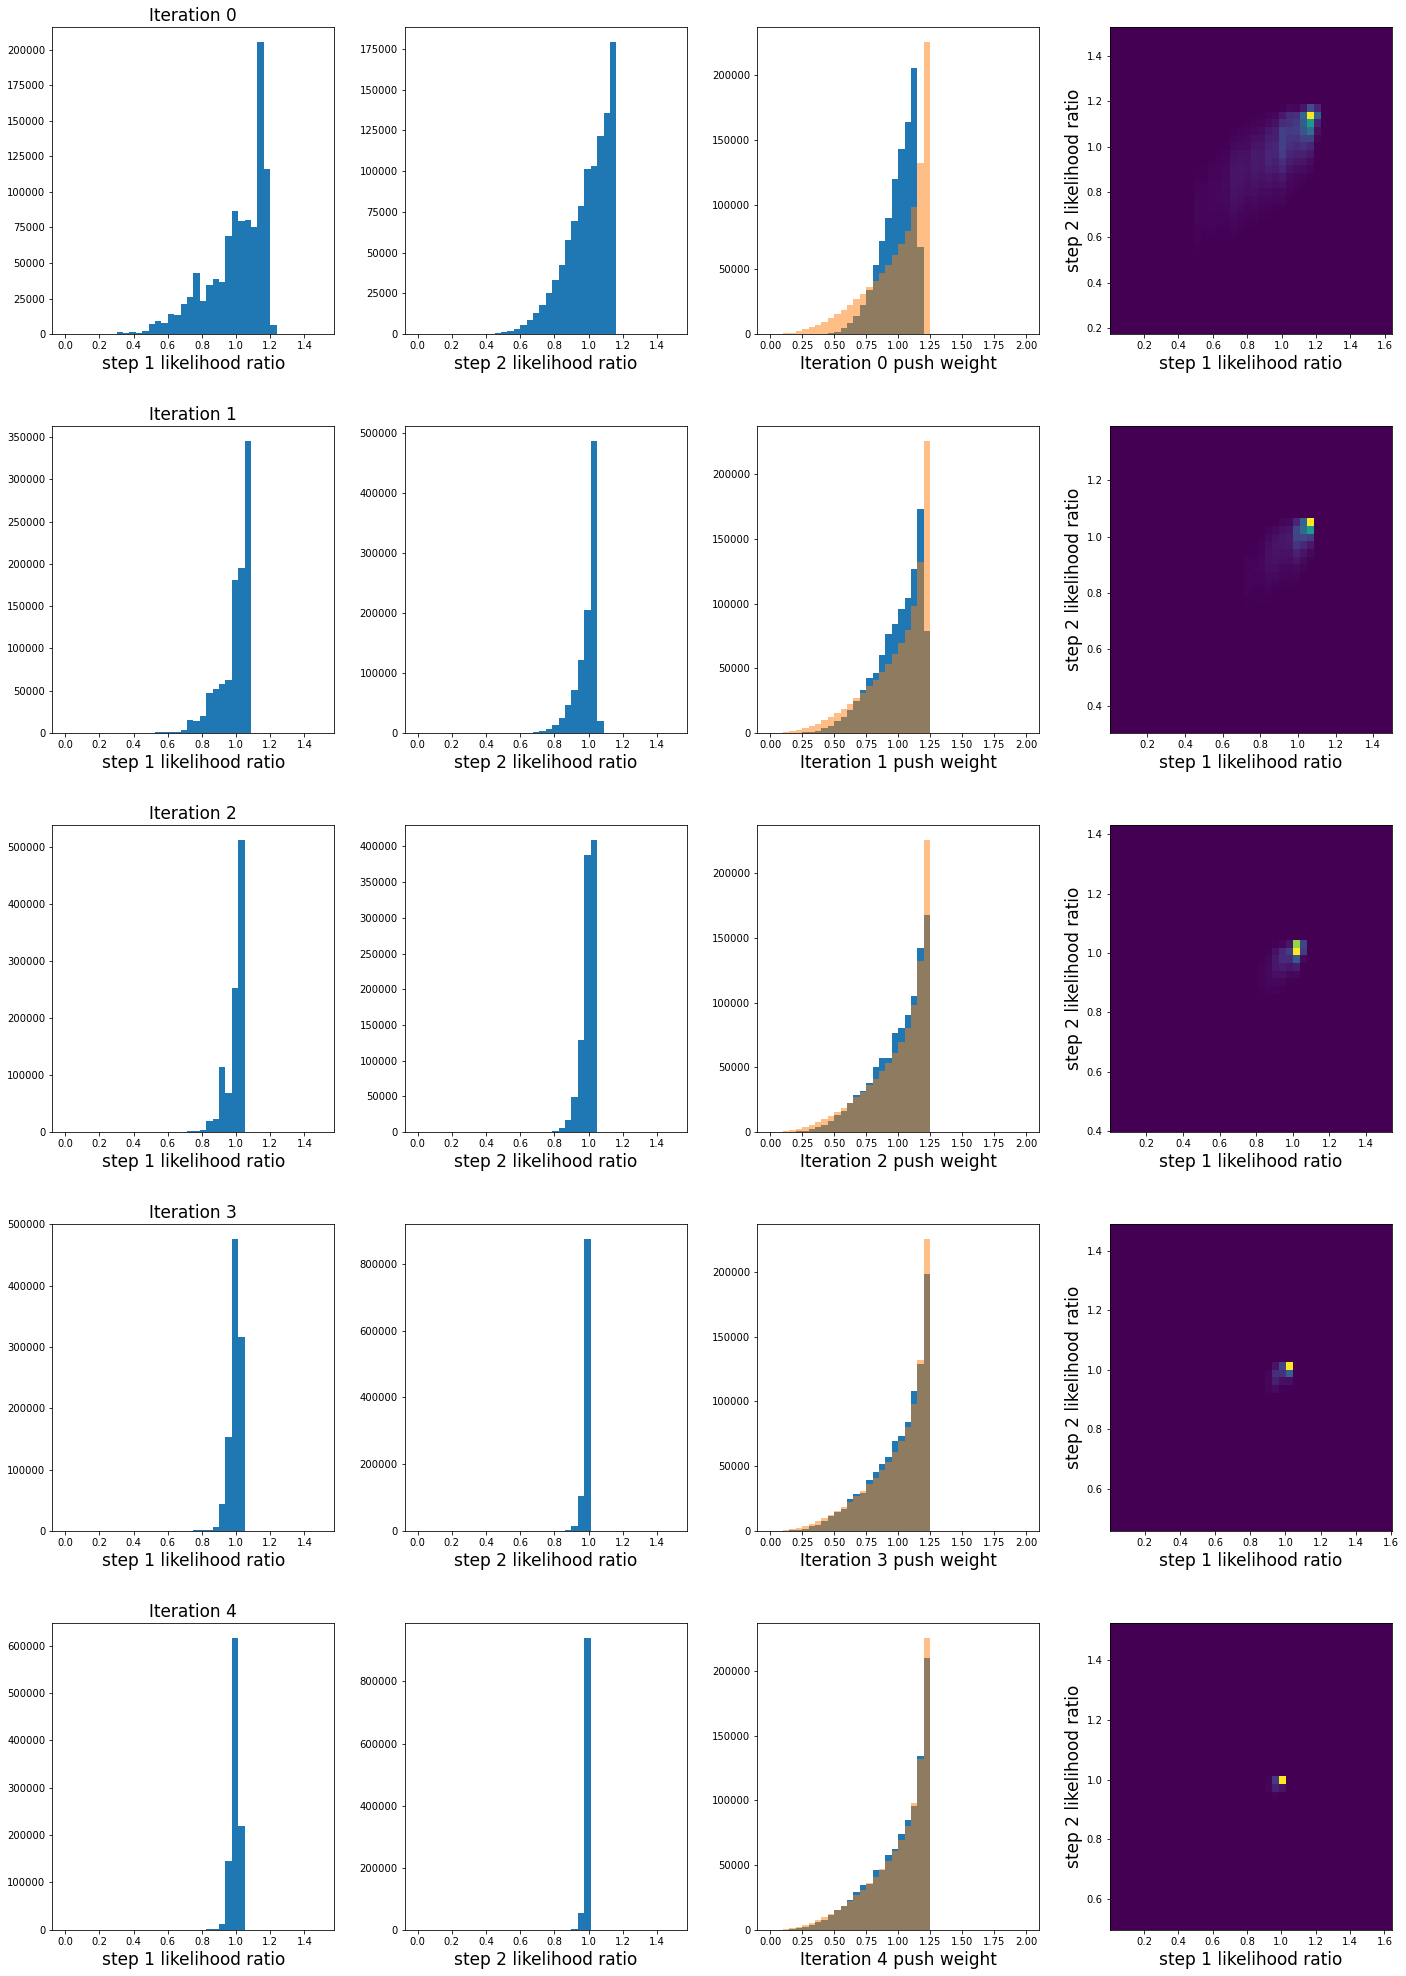

In [66]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

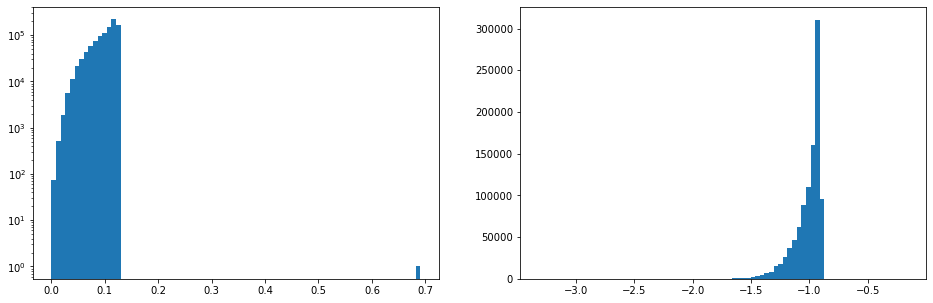

In [67]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

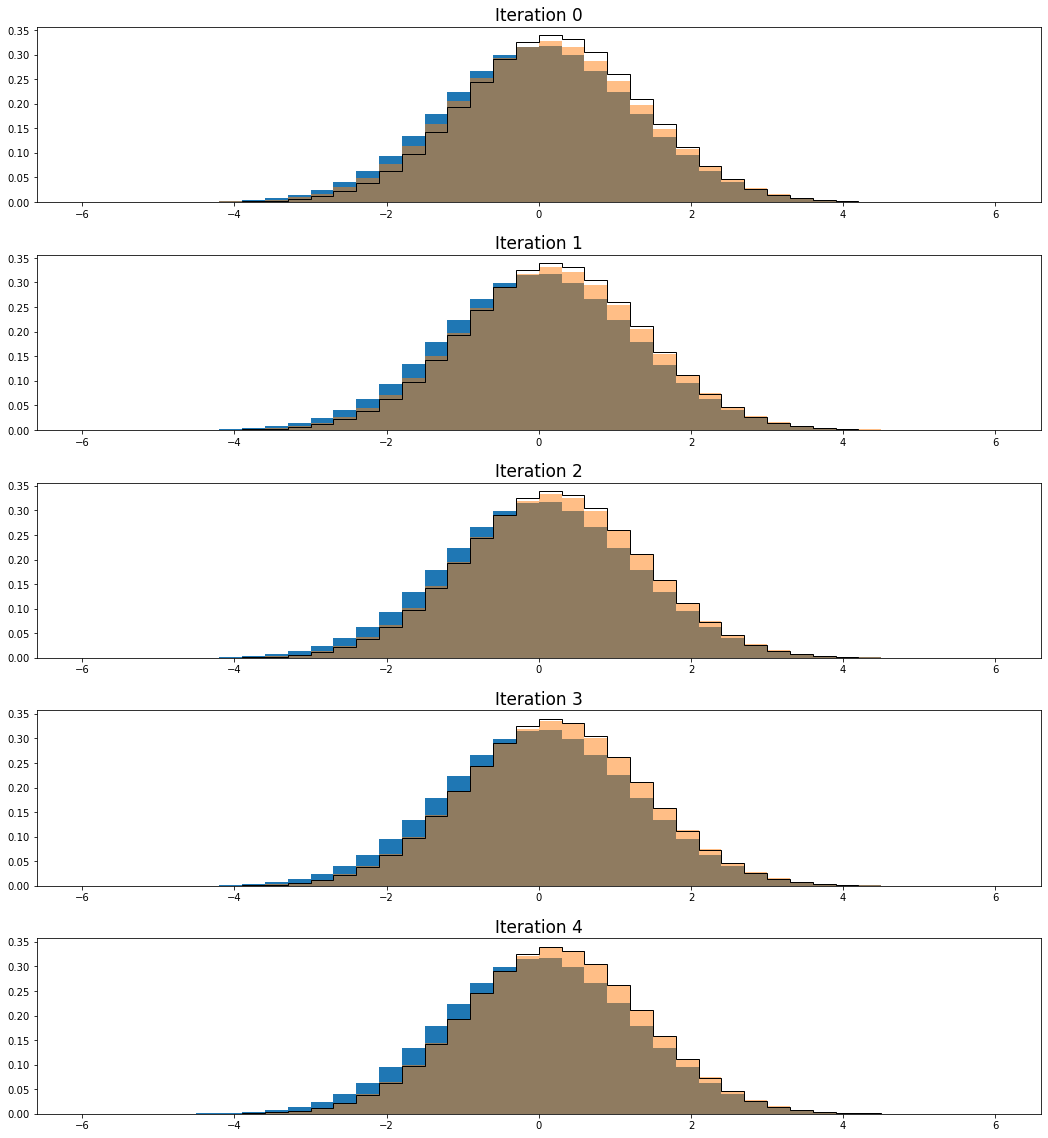

In [68]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [69]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

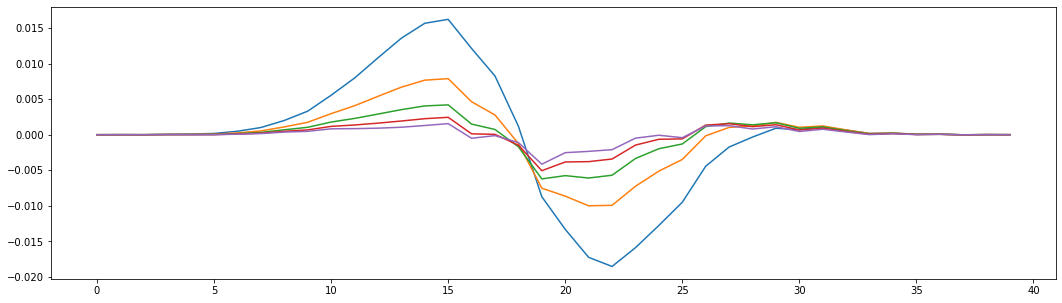

In [70]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

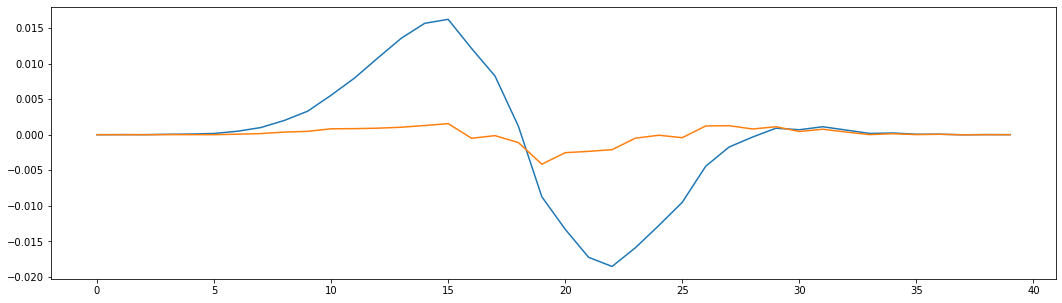

In [71]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

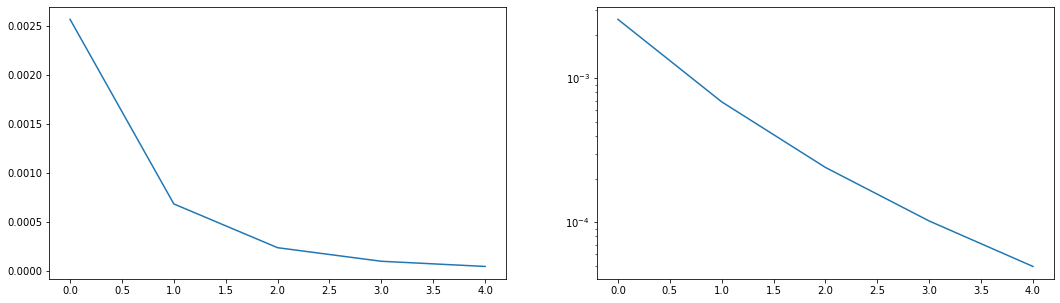

In [72]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [73]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.000  rms 0.173      step 2 mean  1.000  rms 0.130
  iter  1 : step 1 mean  0.992  rms 0.088      step 2 mean  0.992  rms 0.063
  iter  2 : step 1 mean  0.994  rms 0.051      step 2 mean  0.995  rms 0.034
  iter  3 : step 1 mean  0.997  rms 0.033      step 2 mean  0.997  rms 0.020
  iter  4 : step 1 mean  0.998  rms 0.023      step 2 mean  0.998  rms 0.012


<function matplotlib.pyplot.show(close=None, block=None)>

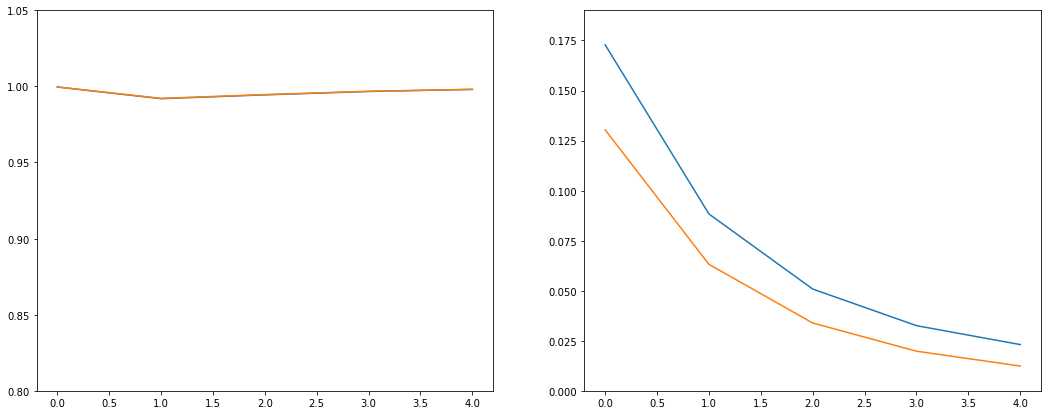

In [74]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

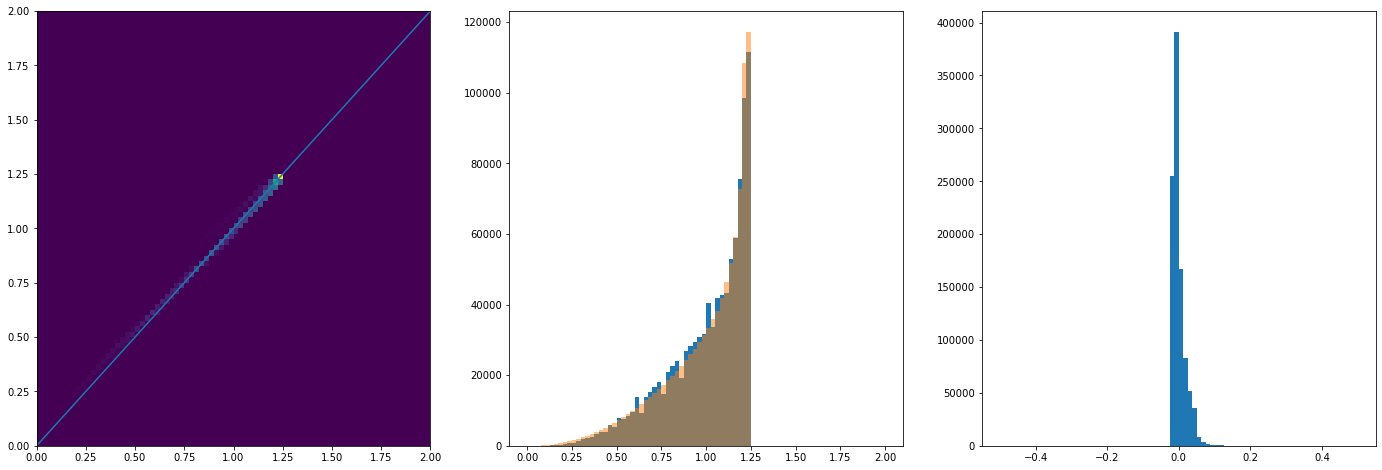

In [75]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [76]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.01867




In [77]:

verbose = False



import gc

In [78]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        #print("\n Creating bootstrap sample %3d" % bi )
        #boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        fname = "%s/bootstrap-points-%03d.npy" % (ds_input_dir, bi)
        print('\n Reading bootstrap sample from file: %s' % fname )
        with open( fname, 'rb' ) as f :
            boot_true_det_pts = np.load(f)
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        

        
#    boot_of_return_dict = of.omnifold6b( 
#        train_both, boot_true_det_pts, of_niter, model, verbose, 
#        batch_size_setval, learning_rate_setval, epochs_setval )

#    rd = simple_pdf.simple_pdf2b( train_both, boot_true_det_pts, 
#                             train_train_det_within_sphere, train_train_gen_within_sphere,
#                             of_niter, radius, norm_radius2, False, False )

#    rd = fit_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    rd = hist_pdf_omnifold1a( train_both, boot_true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69702204 0.93813752 0.64599889 ... 0.98276725 0.81243968 1.10226878]
 weights_push at the beginning
[0.5788482  0.91208635 0.5143423  ... 0.97726471 0.73323084 1.14984366]
 weights_push at the beginning
[0.52333636 0.90207946 0.45363118 ... 0.97799507 0.69575257 1.17476091]
 weights_push at the beginning
[0.49389324 0.89860592 0.42164573 ... 0.9806518  0.67631358 1.18889415]


 bootstrap 0 final push weights scaled:
[0.04769216 0.08976653 0.04032632 ... 0.09834299 0.06654508 0.11973924]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69392538 0.93501708 0.64259646 ... 0.98066306 0.80867929 1.1039191 ]
 weights_push at the beginning
[0.57570996 0.90728822 0.5107413  ... 0.97387614 0.72851686 1.15195195]
 weights_push at the beginning
[0.52073984 0.89631085 0.45030238 ... 0.97386138 0.69094896 1.17699141]
 we

 weights_push at the beginning
[0.6931126  0.93677375 0.64193793 ... 0.98238943 0.80909933 1.10387564]
 weights_push at the beginning
[0.57401971 0.90993084 0.50957055 ... 0.97667954 0.72848419 1.15233361]
 weights_push at the beginning
[0.51832686 0.89942807 0.44884079 ... 0.97735059 0.69025723 1.17788666]
 weights_push at the beginning
[0.48896075 0.89558902 0.41704545 ... 0.98000539 0.67034492 1.19253538]


 bootstrap 14 final push weights scaled:
[0.04721868 0.08943409 0.03989421 ... 0.09827938 0.06591485 0.12014779]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69172342 0.93743174 0.63812295 ... 0.98226159 0.81032502 1.10194919]
 weights_push at the beginning
[0.57153777 0.91148498 0.50333931 ... 0.9768116  0.73066322 1.14853033]
 weights_push at the beginning
[0.51477821 0.90191545 0.44051605 ... 0.97790185 0.69320321 1.17247681]
 weights_push at the beginning
[0.48436068 0.89895305 0.40677092 ... 0.98100905 0.6



 bootstrap 27 final push weights scaled:
[0.04780087 0.08996359 0.04060383 ... 0.09851669 0.06642585 0.1194114 ]

 Creating toy sample  28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70167923 0.94212304 0.64943814 ... 0.98430923 0.81916829 1.09707912]
 weights_push at the beginning
[0.58354234 0.9189036  0.51694581 ... 0.98018066 0.74278604 1.1410991 ]
 weights_push at the beginning
[0.52695759 0.91104414 0.45464353 ... 0.98201039 0.70671672 1.16329839]
 weights_push at the beginning
[0.49611948 0.90932355 0.42096426 ... 0.98558528 0.68805138 1.17523062]


 bootstrap 28 final push weights scaled:
[0.04776766 0.09098858 0.04009575 ... 0.09891638 0.06776307 0.11818785]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70129317 0.93794214 0.6512771  ... 0.98229873 0.81418573 1.10187178]
 weights_push at the beginning
[0.58506171 0.91159682 0.5216356  ... 0.97635663 0.73592284 1.

 weights_push at the beginning
[0.58660259 0.9118019  0.52651603 ... 0.97639479 0.7345059  1.14611335]
 weights_push at the beginning
[0.53274395 0.90184858 0.46839173 ... 0.9772087  0.69700939 1.1699749 ]
 weights_push at the beginning
[0.50448865 0.89842954 0.43843108 ... 0.98006243 0.67730349 1.18335177]


 bootstrap 41 final push weights scaled:
[0.04884    0.08975395 0.04217233 ... 0.09831051 0.06660028 0.11912924]

 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69622603 0.93477972 0.64425404 ... 0.97930876 0.81095625 1.10185358]
 weights_push at the beginning
[0.57877495 0.90738399 0.51248625 ... 0.97194479 0.73240332 1.14823239]
 weights_push at the beginning
[0.5239975  0.89688881 0.45163361 ... 0.97167979 0.69604665 1.17205748]
 weights_push at the beginning
[0.49507937 0.89325035 0.41928827 ... 0.97375215 0.67773119 1.18532887]


 bootstrap 42 final push weights scaled:
[0.04784382 0.08922541 0.04003662 ... 0.

 weights_push at the beginning
[0.69739722 0.93739242 0.64589769 ... 0.98139056 0.8128897  1.10120468]
 weights_push at the beginning
[0.57963415 0.91133653 0.51421231 ... 0.97525169 0.73445325 1.14759627]
 weights_push at the beginning
[0.52438543 0.90160584 0.45334557 ... 0.97571488 0.69771861 1.17151446]
 weights_push at the beginning
[0.49507497 0.89848889 0.42110816 ... 0.97827118 0.67891046 1.18484702]


 bootstrap 55 final push weights scaled:
[0.04781507 0.08979091 0.04024295 ... 0.09810245 0.06685629 0.11927077]

 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6958591  0.93780858 0.64451687 ... 0.98264441 0.81178623 1.10269668]
 weights_push at the beginning
[0.57731818 0.91157975 0.51239911 ... 0.9770665  0.73234555 1.15054303]
 weights_push at the beginning
[0.5216414  0.90146574 0.45145031 ... 0.9777572  0.69477696 1.1756923 ]
 weights_push at the beginning
[0.49211028 0.89790949 0.41930405 ... 0.98038302 0.6

 weights_push at the beginning
[0.4770226  0.90150507 0.4043379  ... 0.98551951 0.66613299 1.18642705]


 bootstrap 68 final push weights scaled:
[0.0458763  0.09014774 0.03850559 ... 0.09895165 0.0654154  0.11938829]

 Creating toy sample  69
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69577954 0.93716908 0.64620433 ... 0.98268854 0.81021831 1.10404169]
 weights_push at the beginning
[0.57769009 0.91027712 0.51561239 ... 0.97696258 0.72980845 1.15298942]
 weights_push at the beginning
[0.52261761 0.89955279 0.45613024 ... 0.97745831 0.69153185 1.17900013]
 weights_push at the beginning
[0.49373071 0.89545949 0.42539961 ... 0.9798985  0.67149508 1.19403006]


 bootstrap 69 final push weights scaled:
[0.04773455 0.08939769 0.04082473 ... 0.09824838 0.06601501 0.12032833]

 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69378542 0.93471767 0.64498364 ... 0.98145688 0.80613009 1.

 weights_push at the beginning
[0.58737229 0.91368802 0.52681357 ... 0.97826083 0.736103   1.14228799]
 weights_push at the beginning
[0.53335601 0.90426872 0.46843002 ... 0.97983487 0.69871181 1.16486008]
 weights_push at the beginning
[0.5049365  0.90122913 0.43826701 ... 0.98335199 0.67896981 1.17717836]


 bootstrap 82 final push weights scaled:
[0.04887271 0.09006068 0.04214528 ... 0.09869798 0.06675606 0.11842204]

 Creating toy sample  83
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70054207 0.93720346 0.64988148 ... 0.9817719  0.81329754 1.1012676 ]
 weights_push at the beginning
[0.58439976 0.9106282  0.51988601 ... 0.97570618 0.73494391 1.14806562]
 weights_push at the beginning
[0.53040453 0.9002348  0.46019495 ... 0.97607723 0.69821446 1.17244196]
 weights_push at the beginning
[0.50222872 0.89640956 0.42896447 ... 0.97847183 0.67940429 1.18621305]


 bootstrap 83 final push weights scaled:
[0.04863808 0.08951188 0.04112062 ... 0.



 bootstrap 95 final push weights scaled:
[0.04921948 0.08932763 0.0414279  ... 0.09759209 0.06758245 0.11943269]

 Creating toy sample  96
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69035964 0.93579435 0.63734167 ... 0.98162065 0.80812018 1.10482167]
 weights_push at the beginning
[0.57014801 0.90848461 0.50295513 ... 0.97537404 0.72751694 1.15358597]
 weights_push at the beginning
[0.51370397 0.89778475 0.44073992 ... 0.97569171 0.68963248 1.17922076]
 weights_push at the beginning
[0.48369119 0.89387373 0.40759922 ... 0.97809041 0.67018907 1.19385815]


 bootstrap 96 final push weights scaled:
[0.04663093 0.08926088 0.0388198  ... 0.09806715 0.06595127 0.12027476]

 Creating toy sample  97
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69064945 0.93922007 0.63964648 ... 0.9842459  0.80930567 1.10064088]
 weights_push at the beginning
[0.56973471 0.91435567 0.5061114  ... 0.98036205 0.72814666 1.



 bootstrap 109 final push weights scaled:
[0.04811252 0.08950412 0.04073039 ... 0.09783961 0.06677443 0.11945807]

 Creating toy sample 110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69712799 0.93971361 0.64407678 ... 0.98316162 0.81507065 1.10008674]
 weights_push at the beginning
[0.5781061  0.91499608 0.51042969 ... 0.97816006 0.7372271  1.14596204]
 weights_push at the beginning
[0.52152461 0.90612482 0.4478129  ... 0.97936424 0.70062005 1.16954538]
 weights_push at the beginning
[0.4909795  0.90363016 0.41403769 ... 0.9824372  0.68181098 1.18260815]


 bootstrap 110 final push weights scaled:
[0.04729475 0.09035415 0.03940021 ... 0.09855711 0.06714432 0.1190229 ]

 Creating toy sample 111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69863886 0.93836    0.64985997 ... 0.98279505 0.81203394 1.10026802]
 weights_push at the beginning
[0.58147888 0.91272057 0.52037232 ... 0.97771117 0.73243029 



 bootstrap 123 final push weights scaled:
[0.04815831 0.09002206 0.04068273 ... 0.09800187 0.0674012  0.11852851]

 Creating toy sample 124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69926261 0.93713621 0.64925192 ... 0.98129964 0.81274949 1.1017353 ]
 weights_push at the beginning
[0.58254512 0.91071413 0.51933508 ... 0.97494927 0.73407695 1.14863444]
 weights_push at the beginning
[0.52813419 0.9006135  0.45985397 ... 0.97517036 0.6971095  1.1729251 ]
 weights_push at the beginning
[0.49956109 0.89717062 0.4288373  ... 0.97750884 0.67808476 1.18651426]


 bootstrap 124 final push weights scaled:
[0.04832912 0.08963202 0.041126   ... 0.09800865 0.06675304 0.11945424]

 Creating toy sample 125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69150054 0.93577731 0.63855639 ... 0.9815203  0.80856098 1.10429312]
 weights_push at the beginning
[0.57200897 0.90848128 0.50473745 ... 0.97525316 0.72827661 



 bootstrap 137 final push weights scaled:
[0.04851934 0.0895964  0.04149664 ... 0.09782606 0.06682486 0.11910253]

 Creating toy sample 138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69376016 0.93463289 0.64450074 ... 0.98005821 0.80767381 1.10281625]
 weights_push at the beginning
[0.57578909 0.90703756 0.51422365 ... 0.97323442 0.7269509  1.1496707 ]
 weights_push at the beginning
[0.52101976 0.89640654 0.45512084 ... 0.97347203 0.68886761 1.17364856]
 weights_push at the beginning
[0.49228175 0.89271502 0.42456777 ... 0.97605919 0.66905177 1.18686016]


 bootstrap 138 final push weights scaled:
[0.04758645 0.08917417 0.04073955 ... 0.09789884 0.06578362 0.11945005]

 Creating toy sample 139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70884554 0.93966564 0.66058696 ... 0.98391944 0.81754592 1.09947764]
 weights_push at the beginning
[0.59544291 0.91387094 0.5340838  ... 0.97898652 0.74022595 

 weights_push at the beginning
[0.53107655 0.906851   0.4614029  ... 0.9820214  0.70105088 1.16963045]
 weights_push at the beginning
[0.50220549 0.90379343 0.42978283 ... 0.98528407 0.68167216 1.1830571 ]


 bootstrap 151 final push weights scaled:
[0.04857842 0.09030951 0.04117903 ... 0.09885366 0.06707334 0.11909935]

 Creating toy sample 152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70116056 0.94427591 0.65155709 ... 0.98895556 0.81584962 1.09911082]
 weights_push at the beginning
[0.58314421 0.92116407 0.52081687 ... 0.98748306 0.73614308 1.14567206]
 weights_push at the beginning
[0.5272812  0.91255959 0.46055717 ... 0.99091889 0.69708411 1.17018116]
 weights_push at the beginning
[0.4976492  0.9097664  0.42924318 ... 0.99555611 0.67582826 1.1840831 ]


 bootstrap 152 final push weights scaled:
[0.0480762  0.09091482 0.04118353 ... 0.09998969 0.066318   0.11923971]

 Creating toy sample 153
 weights_push at the beginning
[1. 1. 1. ..

 weights_push at the beginning
[0.69731201 0.94110647 0.64368338 ... 0.98463434 0.81575588 1.09926315]
 weights_push at the beginning
[0.57804235 0.91709468 0.50947234 ... 0.98060862 0.73786787 1.14471974]
 weights_push at the beginning
[0.52123247 0.90859395 0.44640151 ... 0.98249087 0.70101876 1.16803166]
 weights_push at the beginning
[0.49056858 0.90629675 0.41232049 ... 0.98606698 0.68193096 1.18088437]


 bootstrap 165 final push weights scaled:
[0.04725375 0.09063059 0.03921207 ... 0.09895929 0.06712981 0.11883266]

 Creating toy sample 166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7064662  0.93713729 0.6565485  ... 0.98116999 0.81595038 1.09994696]
 weights_push at the beginning
[0.59295126 0.91041724 0.52886642 ... 0.97466894 0.7390656  1.14608054]
 weights_push at the beginning
[0.54064484 0.89979554 0.47040785 ... 0.97464591 0.7033329  1.17009893]
 weights_push at the beginning
[0.51376562 0.895699   0.44000045 ... 0.97668331 0.

 weights_push at the beginning
[0.69472936 0.9392711  0.64516762 ... 0.98516548 0.80990982 1.10337298]
 weights_push at the beginning
[0.57573104 0.91342099 0.51391526 ... 0.98109507 0.72854811 1.15202883]
 weights_push at the beginning
[0.51999418 0.90325973 0.4540849  ... 0.98277903 0.68921824 1.17779808]
 weights_push at the beginning
[0.49066855 0.89950923 0.42325117 ... 0.98614829 0.66818008 1.19256198]


 bootstrap 179 final push weights scaled:
[0.04740294 0.08982596 0.04061831 ... 0.09895067 0.06559222 0.12015149]

 Creating toy sample 180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69742759 0.9342246  0.64660584 ... 0.9777947  0.81161435 1.10094992]
 weights_push at the beginning
[0.58064615 0.90695    0.51608905 ... 0.96968031 0.73368514 1.14637761]
 weights_push at the beginning
[0.52622555 0.89684436 0.4560617  ... 0.96904605 0.69781332 1.169393  ]
 weights_push at the beginning
[0.49743108 0.89369854 0.4242948  ... 0.9709459  0.

 weights_push at the beginning
[0.69167631 0.93783023 0.63928876 ... 0.98323706 0.80914201 1.10277411]
 weights_push at the beginning
[0.5716932  0.91181878 0.50543628 ... 0.97827419 0.72847745 1.1499706 ]
 weights_push at the beginning
[0.51530014 0.90205464 0.44356068 ... 0.97965017 0.69018593 1.17425376]
 weights_push at the beginning
[0.48534884 0.89889511 0.41079268 ... 0.98297998 0.67020775 1.18766729]


 bootstrap 193 final push weights scaled:
[0.04680828 0.08982758 0.03918461 ... 0.09864148 0.06589447 0.11954204]

 Creating toy sample 194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70181931 0.93742137 0.65307717 ... 0.98212287 0.81296173 1.10064303]
 weights_push at the beginning
[0.58640691 0.91094498 0.52487436 ... 0.97640589 0.73413092 1.14711043]
 weights_push at the beginning
[0.53298263 0.90057809 0.46662666 ... 0.97709693 0.69685535 1.17128843]
 weights_push at the beginning
[0.5053003  0.89674547 0.4367031  ... 0.97979403 0.

 weights_push at the beginning
[0.6918426  0.93745577 0.64007364 ... 0.9828272  0.80890144 1.10339843]
 weights_push at the beginning
[0.57217689 0.91120826 0.50684746 ... 0.97753795 0.72817268 1.15115262]
 weights_push at the beginning
[0.51612028 0.90127259 0.4455186  ... 0.97863475 0.68987346 1.17595102]
 weights_push at the beginning
[0.48650014 0.89797606 0.41325455 ... 0.98171233 0.66990703 1.18984716]


 bootstrap 207 final push weights scaled:
[0.04695537 0.08972425 0.03947843 ... 0.09849134 0.06586619 0.11980565]

 Creating toy sample 208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70525416 0.93450024 0.6580207  ... 0.9786889  0.81361386 1.10212441]
 weights_push at the beginning
[0.59199452 0.90635243 0.53245569 ... 0.97051744 0.73590184 1.14978287]
 weights_push at the beginning
[0.54011419 0.89489081 0.47599623 ... 0.96930525 0.69977692 1.17504975]
 weights_push at the beginning
[0.5135389  0.89026672 0.44733778 ... 0.97043349 0.

 weights_push at the beginning
[0.70017458 0.94017124 0.65026977 ... 0.98387423 0.81508466 1.09957667]
 weights_push at the beginning
[0.5825697  0.91547477 0.51967212 ... 0.97935017 0.73662415 1.14550078]
 weights_push at the beginning
[0.52698244 0.90642298 0.45934879 ... 0.98087491 0.69920422 1.16926058]
 weights_push at the beginning
[0.49724664 0.90368596 0.42755954 ... 0.98420813 0.679522   1.18251838]


 bootstrap 221 final push weights scaled:
[0.04798948 0.09033557 0.04093032 ... 0.09875891 0.06682705 0.11903195]

 Creating toy sample 222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69746661 0.93673209 0.64741904 ... 0.98106658 0.81184348 1.10212288]
 weights_push at the beginning
[0.58013166 0.91015524 0.51708699 ... 0.97459658 0.73283454 1.14897708]
 weights_push at the beginning
[0.52539501 0.90005165 0.45748868 ... 0.97480869 0.69573057 1.17305096]
 weights_push at the beginning
[0.49658421 0.89668694 0.42643503 ... 0.97720821 0.



 bootstrap 234 final push weights scaled:
[0.04923993 0.08967969 0.04191529 ... 0.09815288 0.06716916 0.11891466]

 Creating toy sample 235
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69660219 0.93642751 0.64747961 ... 0.98129556 0.81039663 1.10299358]
 weights_push at the beginning
[0.57908338 0.9095427  0.51755747 ... 0.97496983 0.73044978 1.15087747]
 weights_push at the beginning
[0.5243348  0.89910471 0.45841903 ... 0.97524369 0.69258839 1.17602342]
 weights_push at the beginning
[0.49557407 0.8953874  0.42781688 ... 0.97763588 0.67284883 1.19037834]


 bootstrap 235 final push weights scaled:
[0.04791713 0.08943011 0.04106466 ... 0.09802573 0.06616901 0.11991037]

 Creating toy sample 236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69972607 0.94013573 0.6485499  ... 0.98396682 0.81526738 1.10029928]
 weights_push at the beginning
[0.58187569 0.91526585 0.5169556  ... 0.97929904 0.73703638 

 weights_push at the beginning
[0.53793081 0.89908756 0.46909677 ... 0.97303703 0.70242186 1.17386645]
 weights_push at the beginning
[0.51048375 0.89495504 0.43861484 ... 0.97458134 0.68424511 1.18804565]


 bootstrap 248 final push weights scaled:
[0.04951235 0.08934418 0.0421331  ... 0.09764084 0.06744399 0.11966467]

 Creating toy sample 249
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6990712  0.93527278 0.64995382 ... 0.97944607 0.81156294 1.10075789]
 weights_push at the beginning
[0.58287363 0.90819104 0.52103111 ... 0.97229204 0.73285184 1.1465622 ]
 weights_push at the beginning
[0.52890113 0.89790189 0.46232556 ... 0.97222946 0.69603763 1.17001947]
 weights_push at the beginning
[0.50057691 0.89442958 0.43184899 ... 0.97451186 0.67711621 1.18302662]


 bootstrap 249 final push weights scaled:
[0.04843885 0.0893594  0.04146245 ... 0.09771318 0.06665755 0.11906636]

 Creating toy sample 250
 weights_push at the beginning
[1. 1. 1. ..

 weights_push at the beginning
[0.69949114 0.93577267 0.64870086 ... 0.98031973 0.81240581 1.10227927]
 weights_push at the beginning
[0.58328931 0.90849423 0.51861245 ... 0.97327476 0.73407725 1.14953572]
 weights_push at the beginning
[0.52938249 0.89775616 0.45894544 ... 0.97296703 0.6976404  1.17418081]
 weights_push at the beginning
[0.50126989 0.89376207 0.42769064 ... 0.97485343 0.67919132 1.18814575]


 bootstrap 262 final push weights scaled:
[0.04854244 0.08923947 0.04098351 ... 0.09770151 0.06692147 0.11965688]

 Creating toy sample 263
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70023666 0.9353065  0.65177601 ... 0.98001532 0.811551   1.10324558]
 weights_push at the beginning
[0.5846414  0.90760711 0.5237425  ... 0.9726541  0.73253362 1.15139678]
 weights_push at the beginning
[0.53128215 0.8965114  0.4658448  ... 0.972051   0.69548776 1.17678232]
 weights_push at the beginning
[0.50364322 0.89223725 0.43619673 ... 0.97368893 0.



 bootstrap 275 final push weights scaled:
[0.04712018 0.09011264 0.03988629 ... 0.09895521 0.06605346 0.11955226]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69999791 0.93835451 0.64777522 ... 0.9820581  0.81525118 1.10153557]
 weights_push at the beginning
[0.58275483 0.91251649 0.51593444 ... 0.9760205  0.73778257 1.14874496]
 weights_push at the beginning
[0.52760681 0.90267341 0.4545936  ... 0.97626849 0.70162994 1.17350117]
 weights_push at the beginning
[0.49831422 0.89931938 0.42184551 ... 0.97846921 0.6833049  1.18760852]


 bootstrap 276 final push weights scaled:
[0.04814001 0.08984618 0.04026683 ... 0.09808098 0.06734232 0.11961756]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69689925 0.94017916 0.64610327 ... 0.9843527  0.81351801 1.09973143]
 weights_push at the beginning
[0.57787855 0.91557422 0.51395385 ... 0.98026159 0.73426451 



 bootstrap 289 final push weights scaled:
[0.04827383 0.08994324 0.04101522 ... 0.09807467 0.06720133 0.11866474]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6923748  0.93594527 0.64118282 ... 0.98204205 0.80774083 1.10462248]
 weights_push at the beginning
[0.57353574 0.90856299 0.50894826 ... 0.97605849 0.72670081 1.15326939]
 weights_push at the beginning
[0.51832937 0.89771043 0.4484962  ... 0.97656876 0.68838517 1.17876433]
 weights_push at the beginning
[0.48952153 0.89362996 0.41700296 ... 0.97914337 0.66852227 1.19323122]


 bootstrap 290 final push weights scaled:
[0.047333   0.08922022 0.03992007 ... 0.09819053 0.06574333 0.12019243]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6925218  0.93720066 0.64163135 ... 0.98255844 0.80868182 1.10240492]
 weights_push at the beginning
[0.57336745 0.91096369 0.5093458  ... 0.97731581 0.72788169 



 bootstrap 303 final push weights scaled:
[0.04747859 0.09057716 0.03961557 ... 0.0986638  0.06739015 0.11838035]

 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70316558 0.93765982 0.65174559 ... 0.98103628 0.8164527  1.10063076]
 weights_push at the beginning
[0.58730912 0.91144065 0.52143425 ... 0.97435648 0.73977837 1.14712451]
 weights_push at the beginning
[0.53295162 0.90134916 0.46092015 ... 0.97415781 0.70420439 1.17127938]
 weights_push at the beginning
[0.50412502 0.89782201 0.42864432 ... 0.97604051 0.68630916 1.18486991]


 bootstrap 304 final push weights scaled:
[0.04874511 0.08968427 0.04096948 ... 0.09781569 0.0676746  0.11929802]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69868427 0.94014469 0.64693553 ... 0.98374189 0.81507963 1.09934169]
 weights_push at the beginning
[0.58044489 0.91560778 0.51469577 ... 0.97921244 0.73694152 



 bootstrap 317 final push weights scaled:
[0.04844775 0.08969488 0.0409333  ... 0.09823234 0.06685747 0.1193309 ]

 Creating toy sample 318
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.698853   0.93996668 0.6462995  ... 0.98355912 0.81555884 1.09915751]
 weights_push at the beginning
[0.5805736  0.9153142  0.51350176 ... 0.97888691 0.73781485 1.14452924]
 weights_push at the beginning
[0.52447566 0.90638335 0.45141944 ... 0.9803426  0.7011504  1.1678242 ]
 weights_push at the beginning
[0.49432614 0.90375505 0.41808181 ... 0.98361276 0.68221244 1.18071773]


 bootstrap 318 final push weights scaled:
[0.04766551 0.09034898 0.03984467 ... 0.09869076 0.06716835 0.11882401]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7082432  0.94047972 0.65831584 ... 0.98319781 0.81980831 1.09863043]
 weights_push at the beginning
[0.5938696  0.91563386 0.53002215 ... 0.9778522  0.74390263 

 weights_push at the beginning
[0.52671937 0.91035923 0.4551439  ... 0.98410572 0.70374674 1.16494164]
 weights_push at the beginning
[0.49613594 0.90812372 0.42178868 ... 0.9879839  0.68442958 1.17761277]


 bootstrap 331 final push weights scaled:
[0.04780189 0.09081236 0.04021313 ... 0.09917658 0.0673454  0.1184994 ]

 Creating toy sample 332
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69654964 0.93993282 0.64629007 ... 0.98456379 0.81253592 1.10006446]
 weights_push at the beginning
[0.57768975 0.91507852 0.51461236 ... 0.98059917 0.73272595 1.14607303]
 weights_push at the beginning
[0.52150816 0.90592949 0.45390656 ... 0.98264792 0.69439718 1.16978384]
 weights_push at the beginning
[0.49145578 0.90311161 0.42200048 ... 0.98646363 0.67401664 1.18292891]


 bootstrap 332 final push weights scaled:
[0.04739445 0.09026962 0.04037704 ... 0.09902811 0.06621916 0.11905824]

 Creating toy sample 333
 weights_push at the beginning
[1. 1. 1. ..

 weights_push at the beginning
[0.69876785 0.93877113 0.64536408 ... 0.98291148 0.81462487 1.10089733]
 weights_push at the beginning
[0.58101279 0.9131767  0.51233993 ... 0.97754913 0.73682002 1.14745709]
 weights_push at the beginning
[0.52558778 0.90348556 0.4501542  ... 0.97837097 0.70043809 1.17162886]
 weights_push at the beginning
[0.49616098 0.90021294 0.41673492 ... 0.98106407 0.68194197 1.1852066 ]


 bootstrap 345 final push weights scaled:
[0.04792276 0.08993791 0.0397017  ... 0.09838288 0.06719306 0.11932865]

 Creating toy sample 346
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69556683 0.93725881 0.64485523 ... 0.98188952 0.81128167 1.10253026]
 weights_push at the beginning
[0.57717093 0.91091875 0.51330275 ... 0.9759539  0.73176424 1.15002291]
 weights_push at the beginning
[0.52167028 0.90088179 0.45288073 ... 0.97649531 0.69420279 1.17482189]
 weights_push at the beginning
[0.49227329 0.89748041 0.42120152 ... 0.97907556 0.

 weights_push at the beginning
[0.69445722 0.93958285 0.6417414  ... 0.98418489 0.81226141 1.10103596]
 weights_push at the beginning
[0.57478996 0.91459981 0.50784607 ... 0.97987996 0.73277533 1.14752928]
 weights_push at the beginning
[0.51816148 0.90543836 0.44549169 ... 0.9816405  0.69499208 1.17155181]
 weights_push at the beginning
[0.48784292 0.90264779 0.41218504 ... 0.98518204 0.67525671 1.18492914]


 bootstrap 359 final push weights scaled:
[0.04701978 0.09022632 0.03927294 ... 0.09887208 0.06641245 0.11927746]

 Creating toy sample 360
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69221456 0.93460879 0.6406899  ... 0.97969676 0.80797461 1.10277043]
 weights_push at the beginning
[0.57363985 0.90723625 0.50844117 ... 0.97270201 0.72787346 1.14937746]
 weights_push at the beginning
[0.51851557 0.8969029  0.44780871 ... 0.97285806 0.69048954 1.17317194]
 weights_push at the beginning
[0.48956642 0.89348894 0.41595333 ... 0.97536745 0.

 weights_push at the beginning
[0.69531028 0.93866328 0.64331886 ... 0.98316074 0.81210469 1.10137911]
 weights_push at the beginning
[0.57626674 0.91318006 0.51039386 ... 0.97815809 0.73275475 1.14804693]
 weights_push at the beginning
[0.52010492 0.90372425 0.44876508 ... 0.97941822 0.69516419 1.17218505]
 weights_push at the beginning
[0.49011688 0.90075011 0.41602101 ... 0.98258256 0.67560603 1.18565928]


 bootstrap 373 final push weights scaled:
[0.04726833 0.0900249  0.03969972 ... 0.09858272 0.06646156 0.11935952]

 Creating toy sample 374
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69926457 0.93788777 0.6469404  ... 0.98168384 0.8146389  1.1007174 ]
 weights_push at the beginning
[0.58193556 0.91198566 0.51497391 ... 0.97562195 0.73709093 1.1469535 ]
 weights_push at the beginning
[0.52678814 0.90224001 0.45358477 ... 0.97602717 0.70097068 1.17081261]
 weights_push at the beginning
[0.49748714 0.89903129 0.4207787  ... 0.978461   0.


 Creating toy sample 387
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70269713 0.94057715 0.65336629 ... 0.98487433 0.8154338  1.10061099]
 weights_push at the beginning
[0.58641639 0.91554087 0.52409095 ... 0.98061463 0.73683856 1.14771589]
 weights_push at the beginning
[0.53199657 0.90587116 0.46482586 ... 0.98205219 0.69925101 1.17248044]
 weights_push at the beginning
[0.50346572 0.90244148 0.43410177 ... 0.9851561  0.67947098 1.18655153]


 bootstrap 387 final push weights scaled:
[0.04873747 0.09014201 0.0416959  ... 0.09882587 0.06681948 0.11950091]

 Creating toy sample 388
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69529098 0.93915108 0.64444615 ... 0.98445908 0.81127772 1.10182191]
 weights_push at the beginning
[0.57628592 0.91358072 0.51229909 ... 0.98019226 0.73099431 1.14928999]
 weights_push at the beginning
[0.5202972  0.90377672 0.45146451 ... 0.9818693  0.69251575 1.17426394]
 



 bootstrap 400 final push weights scaled:
[0.04802626 0.08961297 0.04025897 ... 0.09788811 0.06719529 0.11942943]

 Creating toy sample 401
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70318517 0.93707065 0.6558989  ... 0.98214309 0.81289552 1.1017673 ]
 weights_push at the beginning
[0.58828144 0.91001309 0.5290755  ... 0.9761526  0.73372451 1.14944443]
 weights_push at the beginning
[0.5351651  0.89901796 0.47187239 ... 0.97644879 0.69608583 1.1746596 ]
 weights_push at the beginning
[0.50768498 0.89460139 0.44281633 ... 0.9787376  0.67636681 1.18916507]


 bootstrap 401 final push weights scaled:
[0.04923788 0.089278   0.04269856 ... 0.09812194 0.06651457 0.11980592]

 Creating toy sample 402
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69748291 0.94014153 0.64634467 ... 0.98489277 0.8136846  1.10260105]
 weights_push at the beginning
[0.57863346 0.91483515 0.51408552 ... 0.98050268 0.73429003 

 weights_push at the beginning
[0.5228274  0.90062342 0.45331049 ... 0.97698225 0.69427937 1.17900792]
 weights_push at the beginning
[0.49378411 0.8967942  0.42174591 ... 0.97923175 0.67483366 1.19397649]


 bootstrap 414 final push weights scaled:
[0.04772717 0.08955602 0.04038317 ... 0.09816287 0.06640462 0.12031609]

 Creating toy sample 415
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70216341 0.93664415 0.65207817 ... 0.98028981 0.81415425 1.10060798]
 weights_push at the beginning
[0.58688739 0.91011897 0.52301858 ... 0.97343602 0.73659717 1.14669566]
 weights_push at the beginning
[0.53339756 0.90001739 0.46380465 ... 0.97336457 0.70053053 1.17047206]
 weights_push at the beginning
[0.50548924 0.89657889 0.43279728 ... 0.97549809 0.68223965 1.18376607]


 bootstrap 415 final push weights scaled:
[0.04897397 0.08957116 0.04150975 ... 0.09779098 0.06722936 0.11916532]

 Creating toy sample 416
 weights_push at the beginning
[1. 1. 1. ..


 Creating toy sample 428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69433984 0.93865272 0.6403688  ... 0.98226644 0.81359064 1.10177799]
 weights_push at the beginning
[0.57442948 0.91338759 0.50551503 ... 0.97657895 0.73537886 1.1486038 ]
 weights_push at the beginning
[0.51741011 0.9042571  0.44220223 ... 0.97727805 0.69879768 1.17281206]
 weights_push at the beginning
[0.48655932 0.90165504 0.40785939 ... 0.9799531  0.68017693 1.18632863]


 bootstrap 428 final push weights scaled:
[0.04682631 0.09015421 0.03872891 ... 0.09827529 0.06700695 0.11943028]

 Creating toy sample 429
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70146749 0.9369692  0.64956805 ... 0.98117198 0.81439031 1.10126077]
 weights_push at the beginning
[0.58566025 0.91028845 0.51895432 ... 0.97461234 0.73692215 1.14790298]
 weights_push at the beginning
[0.53181805 0.89986382 0.45855575 ... 0.97457306 0.7009983  1.17206471]
 


 Creating toy sample 442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70472348 0.9365851  0.65300099 ... 0.98016727 0.81681656 1.10108168]
 weights_push at the beginning
[0.58989875 0.90961223 0.52320635 ... 0.97282567 0.74070204 1.14823092]
 weights_push at the beginning
[0.53637306 0.89886515 0.46296696 ... 0.97204374 0.70570481 1.1731931 ]
 weights_push at the beginning
[0.50828556 0.89470181 0.43086408 ... 0.97336111 0.68836707 1.18767756]


 bootstrap 442 final push weights scaled:
[0.04923046 0.08930855 0.0412043  ... 0.09749115 0.06793408 0.11967287]

 Creating toy sample 443
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6970546  0.93758289 0.64633732 ... 0.98210799 0.81176819 1.10124895]
 weights_push at the beginning
[0.57941376 0.91153631 0.51524828 ... 0.97650476 0.73254398 1.14777723]
 weights_push at the beginning
[0.52444454 0.90172465 0.45503657 ... 0.97739499 0.69515305 1.1718762 ]
 



 bootstrap 455 final push weights scaled:
[0.04860297 0.0893892  0.04097696 ... 0.09773323 0.06724336 0.11971141]

 Creating toy sample 456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69938869 0.93637049 0.64816468 ... 0.98062647 0.81312331 1.10162132]
 weights_push at the beginning
[0.582708   0.90953264 0.51742688 ... 0.97386062 0.73505837 1.14847765]
 weights_push at the beginning
[0.52823112 0.89913141 0.45712194 ... 0.97377727 0.6987187  1.17286254]
 weights_push at the beginning
[0.49952294 0.89540891 0.42524854 ... 0.97584292 0.68029814 1.18665037]


 bootstrap 456 final push weights scaled:
[0.04830802 0.08942701 0.04067931 ... 0.09781492 0.06703227 0.11949495]

 Creating toy sample 457
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69593122 0.93721586 0.6439975  ... 0.98111534 0.81261101 1.10178653]
 weights_push at the beginning
[0.57737874 0.91113099 0.51150553 ... 0.97477309 0.73410716 



 bootstrap 469 final push weights scaled:
[0.04648846 0.09093406 0.03846422 ... 0.09946274 0.06661546 0.11827353]

 Creating toy sample 470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69967096 0.93766474 0.6494892  ... 0.98240878 0.81312559 1.10313589]
 weights_push at the beginning
[0.58278364 0.91099336 0.5193247  ... 0.97634571 0.73425976 1.15152478]
 weights_push at the beginning
[0.52821809 0.90036696 0.45964297 ... 0.97646736 0.69706493 1.17705766]
 weights_push at the beginning
[0.49957354 0.89633714 0.4284941  ... 0.97855163 0.67790699 1.1916459 ]


 bootstrap 470 final push weights scaled:
[0.04832925 0.08949153 0.04108126 ... 0.09808201 0.06673241 0.12004809]

 Creating toy sample 471
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69091828 0.93908866 0.63778857 ... 0.98368412 0.81104689 1.10322387]
 weights_push at the beginning
[0.56959559 0.91381697 0.50256264 ... 0.97882963 0.7309739  



 bootstrap 483 final push weights scaled:
[0.04793039 0.0889898  0.0407785  ... 0.09757895 0.06634577 0.12034316]

 Creating toy sample 484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.6967393  0.93583155 0.64784496 ... 0.98188334 0.80885343 1.1032303 ]
 weights_push at the beginning
[0.57987317 0.90826692 0.5185886  ... 0.97588044 0.72813048 1.15122879]
 weights_push at the beginning
[0.52594632 0.89714191 0.46020322 ... 0.97637671 0.68978583 1.17641837]
 weights_push at the beginning
[0.49810137 0.8927424  0.4304129  ... 0.9789408  0.66970763 1.19076219]


 bootstrap 484 final push weights scaled:
[0.04826747 0.08909816 0.0414099  ... 0.09817036 0.06582936 0.11994344]

 Creating toy sample 485
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.7012514  0.93695268 0.65122582 ... 0.98084641 0.81410434 1.10117258]
 weights_push at the beginning
[0.58528943 0.91041991 0.52181053 ... 0.97419769 0.73625695 



 bootstrap 497 final push weights scaled:
[0.0492742  0.09009732 0.04150583 ... 0.09843225 0.06780423 0.11877235]

 Creating toy sample 498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.69918811 0.93829325 0.64846171 ... 0.9828221  0.81324576 1.10114744]
 weights_push at the beginning
[0.58192118 0.91234675 0.51760012 ... 0.97747383 0.73441636 1.14804792]
 weights_push at the beginning
[0.52694717 0.902367   0.45727259 ... 0.97835731 0.69711668 1.17255634]
 weights_push at the beginning
[0.49789219 0.89885819 0.42552244 ... 0.98114753 0.67774419 1.18644458]


 bootstrap 498 final push weights scaled:
[0.04812362 0.08978381 0.0407307  ... 0.09840393 0.06668826 0.11948032]

 Creating toy sample 499
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.70019339 0.93575344 0.64951901 ... 0.98033073 0.81281981 1.10238754]
 weights_push at the beginning
[0.58419548 0.90836112 0.51968078 ... 0.97322477 0.73466024 

In [79]:
print('\n\n Done\n\n')



 Done


